In [1]:
import os
import sys

_path = os.path.abspath('../')
if _path not in sys.path:
    sys.path.append(_path)

from pathlib import Path
import requests

from astropy.constants import c as speed_of_light
import astropy.coordinates as coord
from astropy.io import fits
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

from astropy.nddata import StdDevUncertainty
from specutils.spectra import Spectrum1D

from hq.samples_analysis import extract_MAP_sample

from subframe.data import Visit
from subframe.config import sdss_auth

os.environ['APOGEE_CACHE_PATH'] = '/mnt/ceph/users/apricewhelan/apogee'

In [2]:
allstar = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-l33alpha.fits', hdu=1)
allvisit = at.Table.read('/mnt/home/apricewhelan/data/APOGEE_DR17/allVisit-dr17-l33alpha.fits', hdu=1)

In [38]:
apid = '2M19241171+3650235' # KOI-984
# apid = '2M11291785+4853250' # variable control star
visits = allvisit[allvisit['APOGEE_ID'] == apid]
star = allstar[allstar['APOGEE_ID'] == apid]

In [39]:
for row in visits:
    visit = Visit(row)
    visit.frame_times

In [65]:
row = visits[2]
visit = Visit(row)

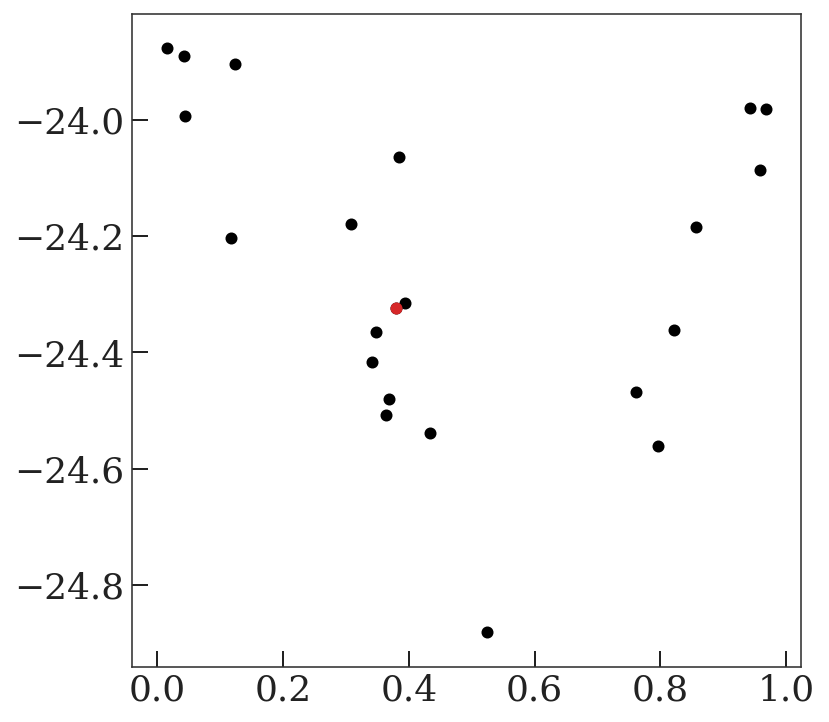

In [66]:
plt.scatter((visits['JD'] / 0.9631649255752563) % 1., visits['VHELIO'])
plt.scatter((row['JD'] / 0.9631649255752563) % 1., row['VHELIO'], color='tab:red')

In [67]:
spectra = visit.load_frame_spectra()

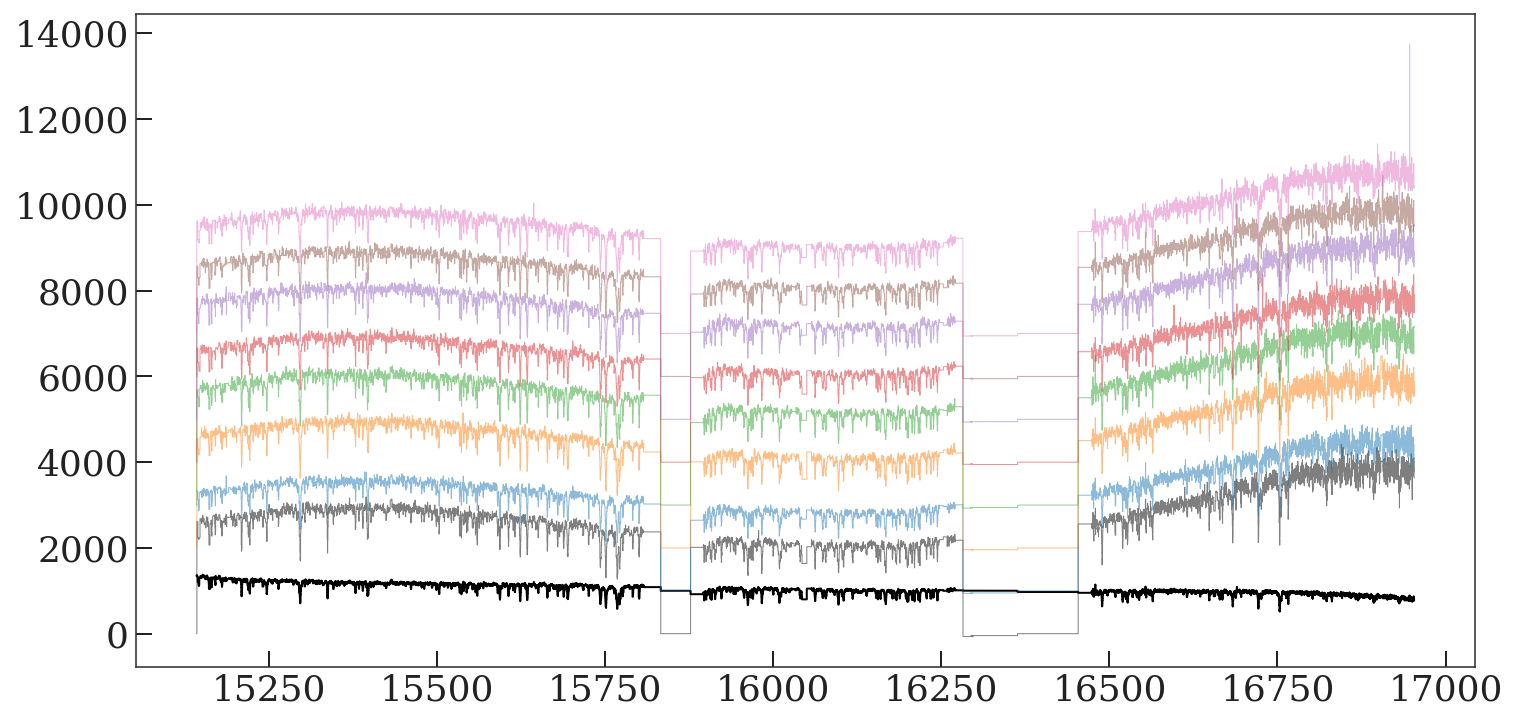

In [68]:
fig = plt.figure(figsize=(12, 6))

plt.plot(visit.spectrum.wavelength,
         visit.spectrum.flux,
         marker='', ls='-', lw=1,
         drawstyle='steps-mid', alpha=1, color='k')

for i, s in enumerate(spectra.values()):
    plt.plot(s.wavelength, 
             s.flux + i*1000, 
             marker='', ls='-', lw=0.5,
             drawstyle='steps-mid', alpha=0.5)

# plt.xlim(16480, 16600)
# plt.ylim(0, 15000)

fig.set_facecolor('w')

In [69]:
# fig = plt.figure(figsize=(12, 6))

# cmap = plt.get_cmap('magma')
# for i, k in enumerate(sorted(spectra.keys())):
#     s = spectra[k]
#     plt.plot(s.wavelength, s.flux, 
#              color=cmap(i/len(spectra)),
#              marker='', ls='-', lw=2,
#              drawstyle='steps-mid', alpha=0.5)

# plt.xlim(16480, 16500)
# plt.ylim(500, 1200)

# fig.set_facecolor('w')

(0.5, 1.5)

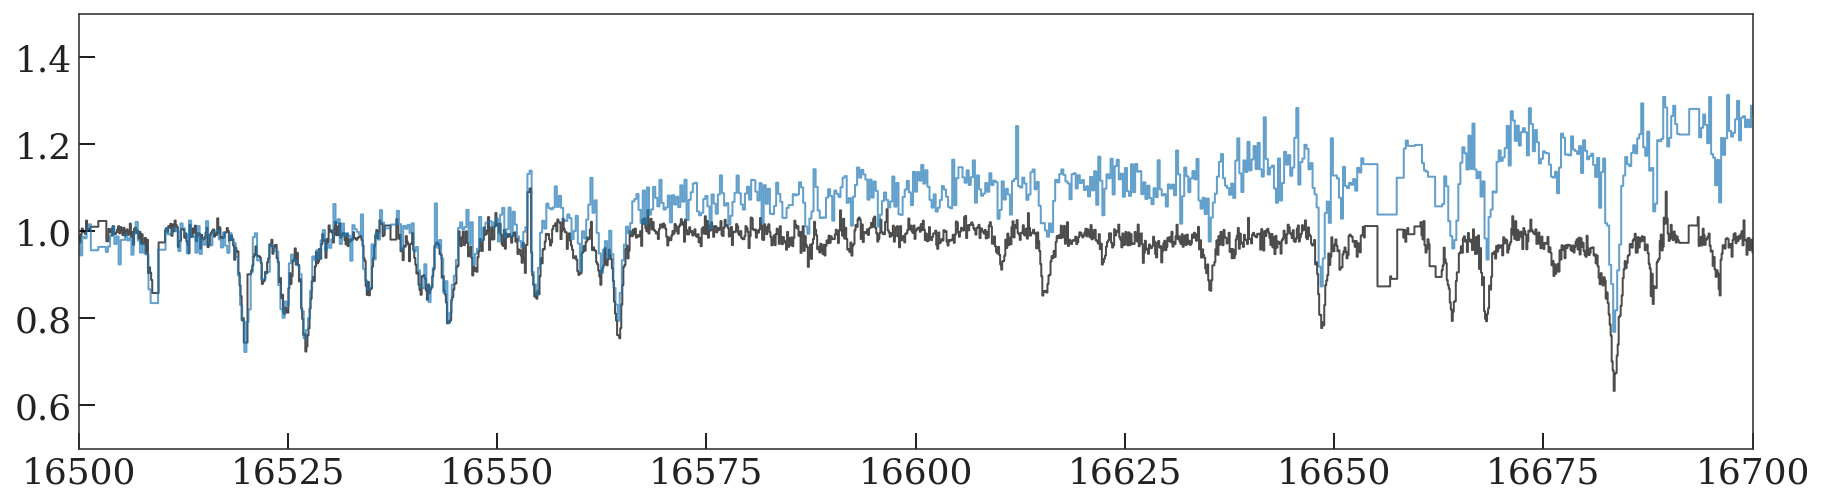

In [70]:
s = list(spectra.values())[0]

fig = plt.figure(figsize=(15, 4))

plt.plot(visit.spectrum.wavelength.value,
         visit.spectrum.flux / np.median(visit.spectrum.flux),
         marker='', ls='-', lw=1,
         drawstyle='steps-mid', alpha=0.7)

plt.plot(s.wavelength.value,
         s.flux / np.median(s.flux),
         marker='', ls='-', lw=1,
         drawstyle='steps-mid', alpha=0.7)
plt.xlim(16500, 16700)
plt.ylim(0.5, 1.5)

---

In [71]:
def doppler_factor(dv):
    return np.sqrt((speed_of_light + dv) / (speed_of_light - dv))

In [72]:
def shift_and_interpolate(ref_spectrum, dv, target_wavelength):
    """
    positive dv = shifting reference spectrum to red
    
    Parameters
    ----------
    
    """
    shifted_wvln = doppler_factor(dv) * ref_spectrum.wavelength.to_value(u.angstrom)
    idx = shifted_wvln.argsort()
    flux_interp = InterpolatedUnivariateSpline(
        shifted_wvln[idx], 
        ref_spectrum.flux.value[idx], 
        k=3, ext=3)
    return flux_interp(target_wavelength.to_value(u.angstrom))

In [73]:
from astropy.stats import sigma_clip

In [74]:
def normalize_ref_to_frame(frame_spectrum, ref_spectrum, deg=4, 
                           sigma_clip=True):
    ref_flux_on_frame_grid = shift_and_interpolate(
        ref_spectrum, 0.*u.km/u.s, frame_spectrum.wavelength)
    
    wvln = frame_spectrum.wavelength.to_value(u.angstrom)
    ref_wvln = np.median(wvln)
    
    # Design matrix
    d_wvln = wvln - ref_wvln
    terms = [ref_flux_on_frame_grid * d_wvln**i 
             for i in range(deg+1)]
    M = np.stack(terms).T
    
    if sigma_clip:
        clipped = sigma_clip(frame_spectrum.flux)
        n_mask = clipped.mask.sum()
        for n in range(1024):  # MAX ITER / infinity
            Cinv = np.ones(len(wvln))
            Cinv[clipped.mask] = 0.

            coeffs = np.linalg.solve(((M.T * Cinv) @ M), 
                                     (M.T * Cinv) @ frame_spectrum.flux)
            warped_flux = M @ coeffs

            clipped = sigma_clip(warped_flux - frame_spectrum.flux, sigma=5)
            if (clipped.mask.sum() - n_mask) < 4 and n > 2:
                break

            n_mask = clipped.mask.sum()
            
        clip_mask = clipped.mask
    
    else:
        coeffs = np.linalg.solve(M.T @ M, 
                                 M.T @ frame_spectrum.flux)
        clip_mask = None
        
    # Design matrix for (larger) apVisit spectrum
    d_wvln = ref_spectrum.wavelength.to_value(u.angstrom) - ref_wvln
    terms = [ref_spectrum.flux.value * d_wvln**i 
             for i in range(deg+1)]
    M = np.stack(terms).T
    normed_spectrum = Spectrum1D(M @ coeffs, spectral_axis=ref_spectrum.wavelength)
    
    return normed_spectrum, clip_mask

In [75]:
def estimate_kernel(frame_spectrum, normed_ref_spectrum, 
                    K_half=2, dv=4.5*u.km/u.s, clip_mask=None):
    
    if clip_mask is None:
        clip_mask = np.zeros(len(frame_spectrum.flux), dtype=bool)
    
    terms = []
    vs = np.arange(-K_half, K_half+1) * dv
    for v in vs:
        shifted_flux = shift_and_interpolate(normed_ref_spectrum, 
                                             v, 
                                             frame_spectrum.wavelength)
        terms.append(shifted_flux)
    M = np.stack(terms).T
    
    # Cinv = np.ones(len(frame_spectrum.flux))
    Cinv = 1 / frame_spectrum.uncertainty.array**2
    Cinv[clip_mask] = 0
    
    kernel = np.linalg.solve((M.T * Cinv) @ M,
                             (M.T * Cinv) @ frame_spectrum.flux)
    kernel_cov = np.linalg.inv((M.T * Cinv) @ M)
    
    denom = np.sqrt(np.diag((M.T * Cinv) @ M) * ((frame_spectrum.flux.T * Cinv) @ frame_spectrum.flux))
    crosscorr = ((M.T * Cinv) @ frame_spectrum.flux) / denom
    
    return kernel, kernel_cov, vs, crosscorr

In [76]:
# mjds = []
# for frame, s in sorted(spectra.items(), key=lambda x: int(x[0])):
#     t = Time(hduls[frame][0].header['DATE-OBS'], scale='tai')
#     mjds.append(t.tcb.mjd)
# mjds = np.array(mjds)

In [77]:
from scipy.optimize import root

def parabola_hack(x, y):
    ps = np.polyfit(x, y, deg=2)
    poly_deriv = np.poly1d(np.polyder(ps))
    return root(poly_deriv, x0=x[1]).x[0], np.poly1d(ps)

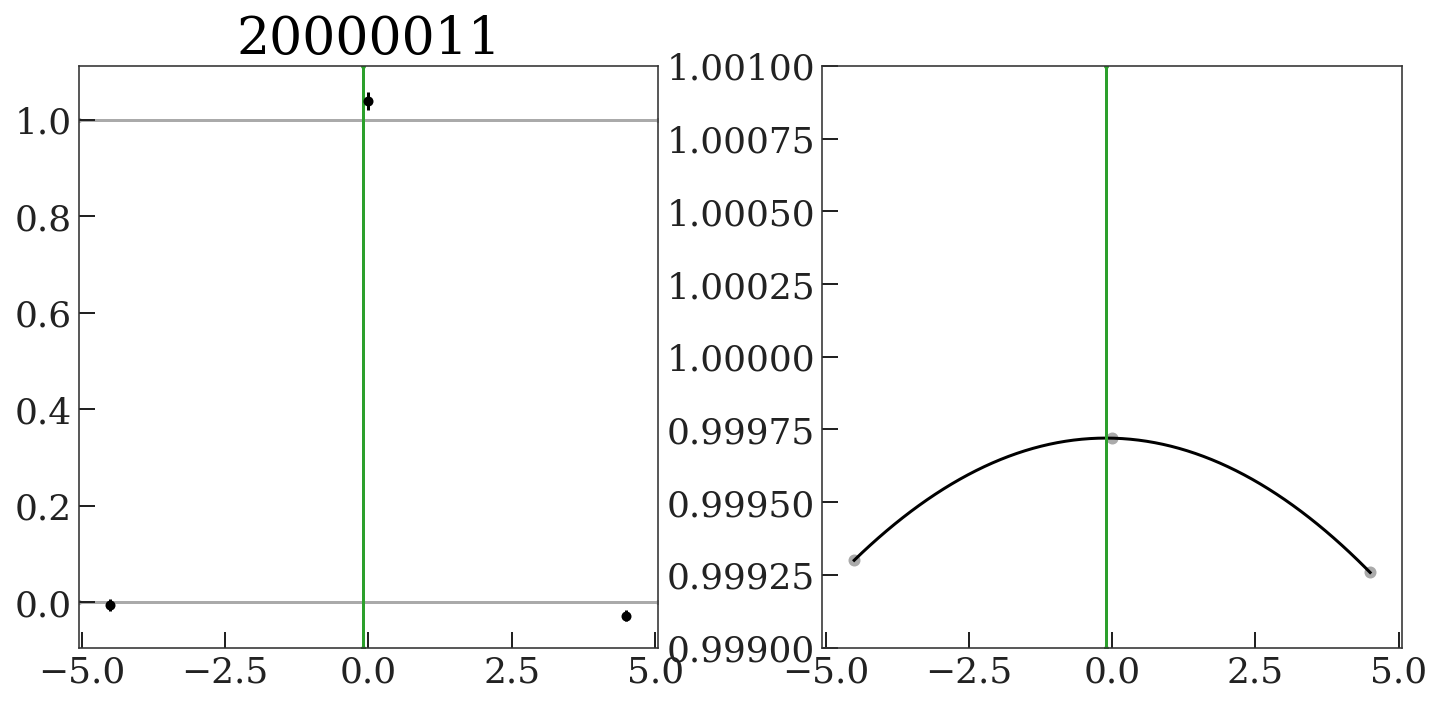

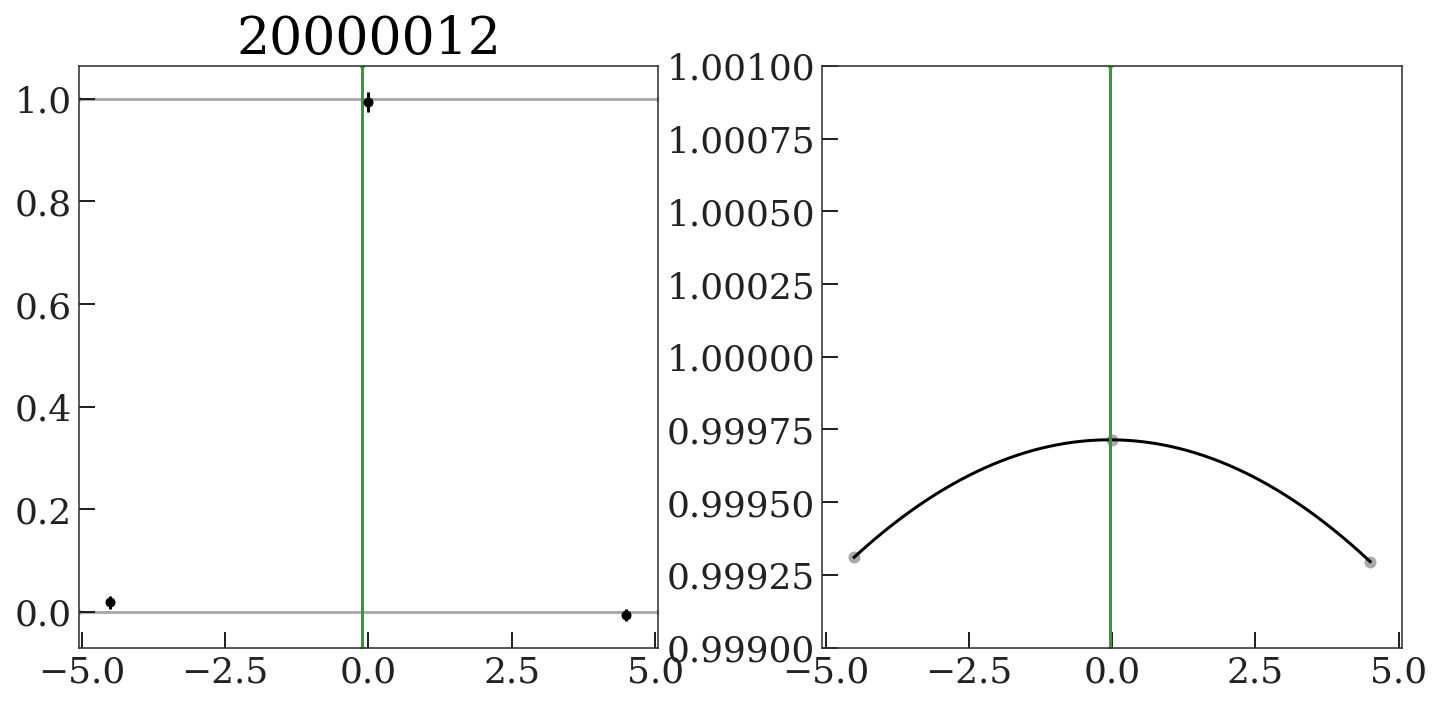

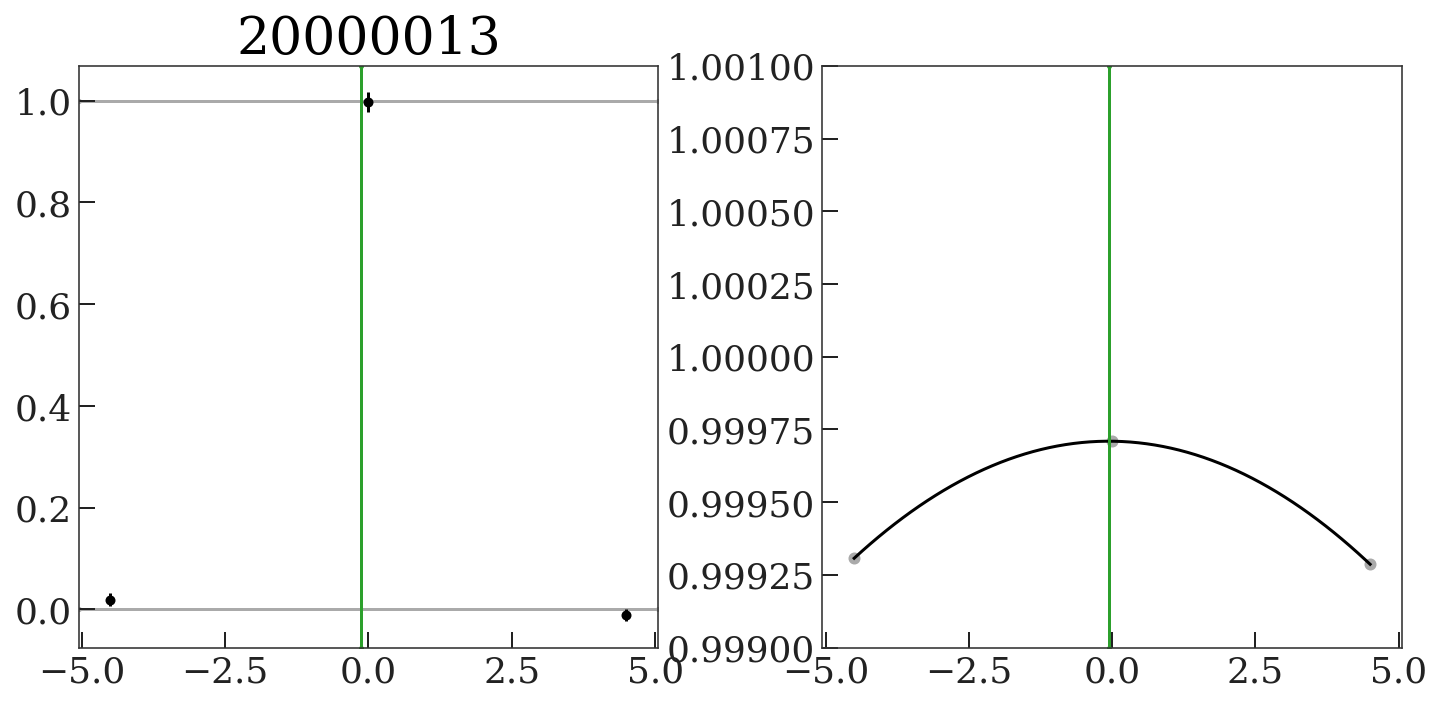

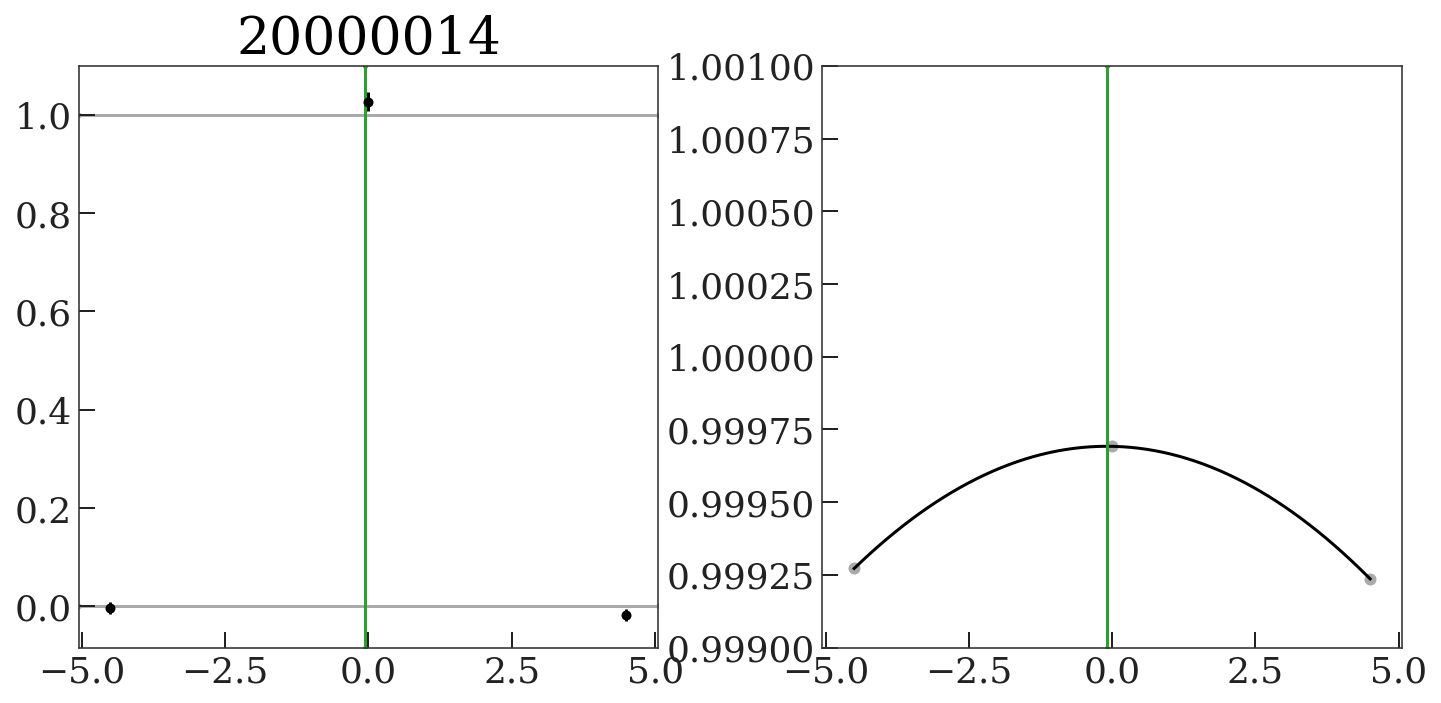

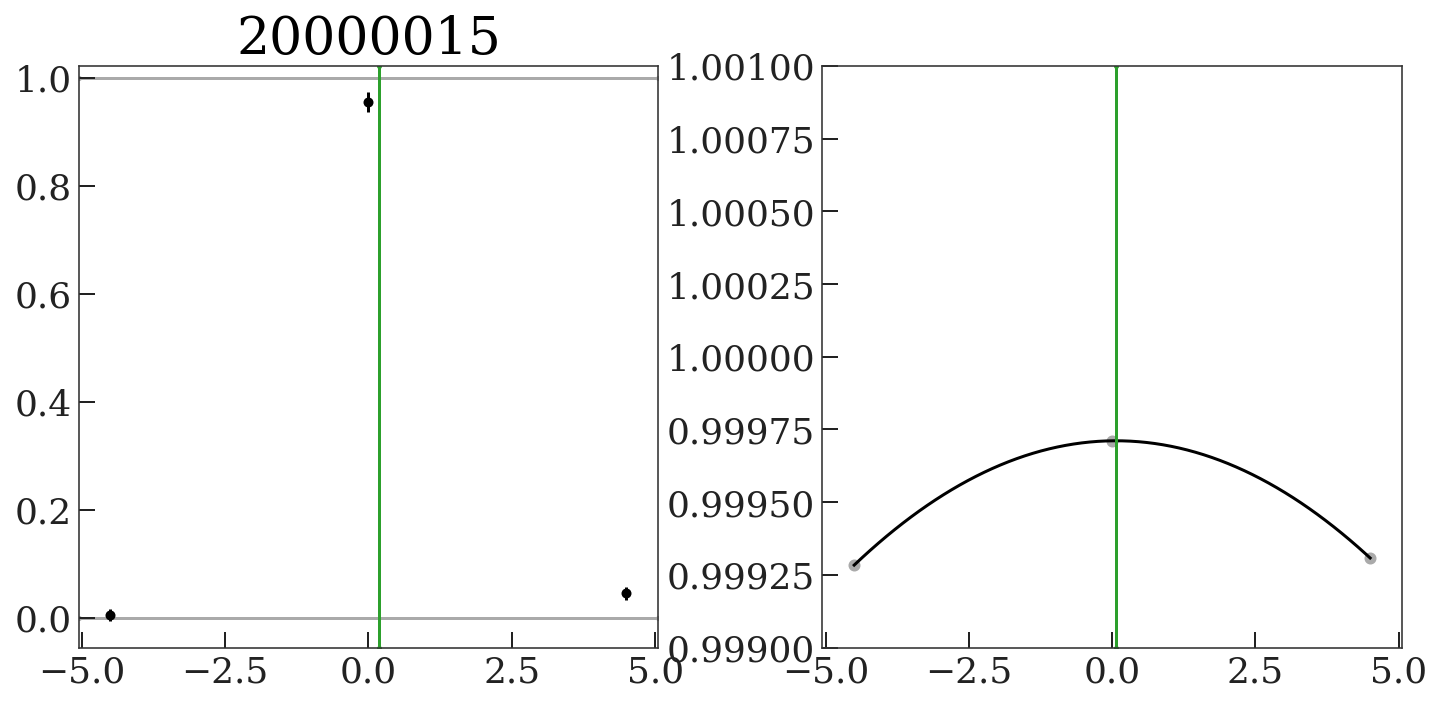

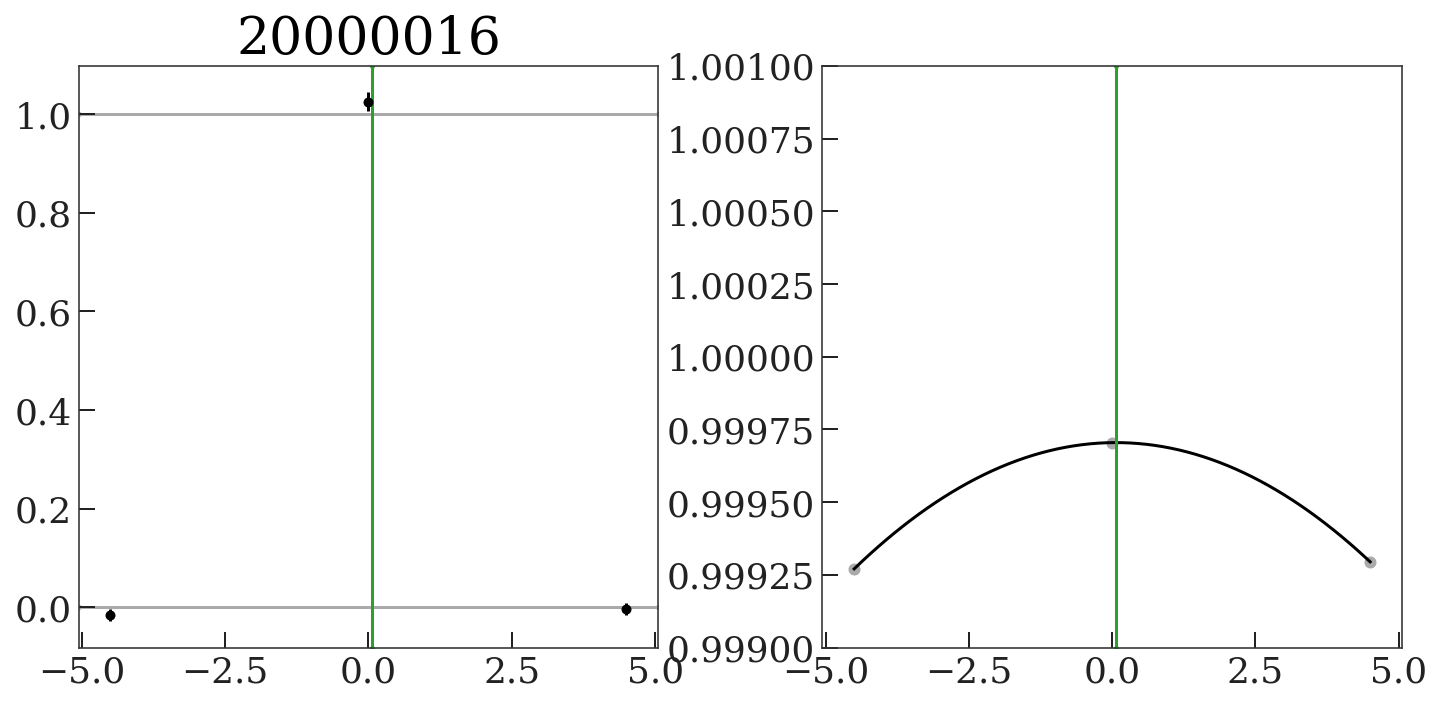

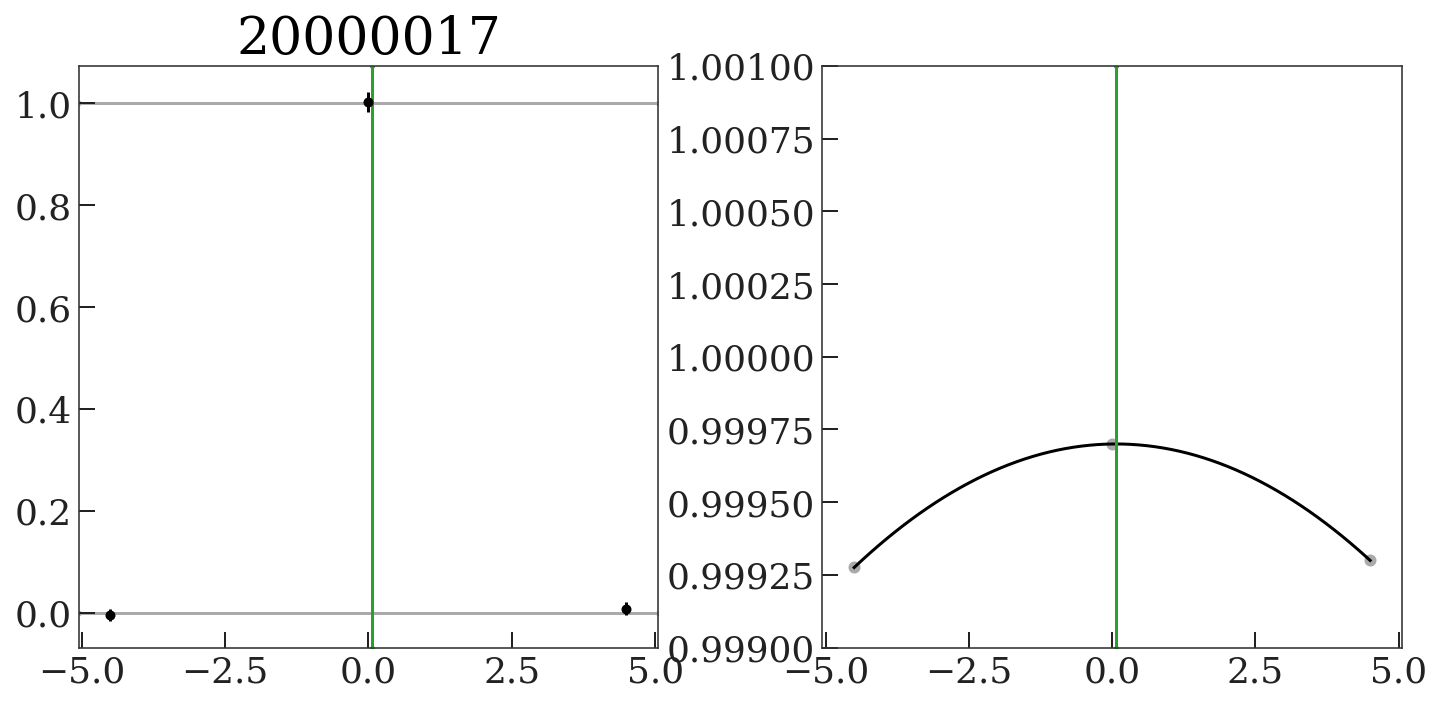

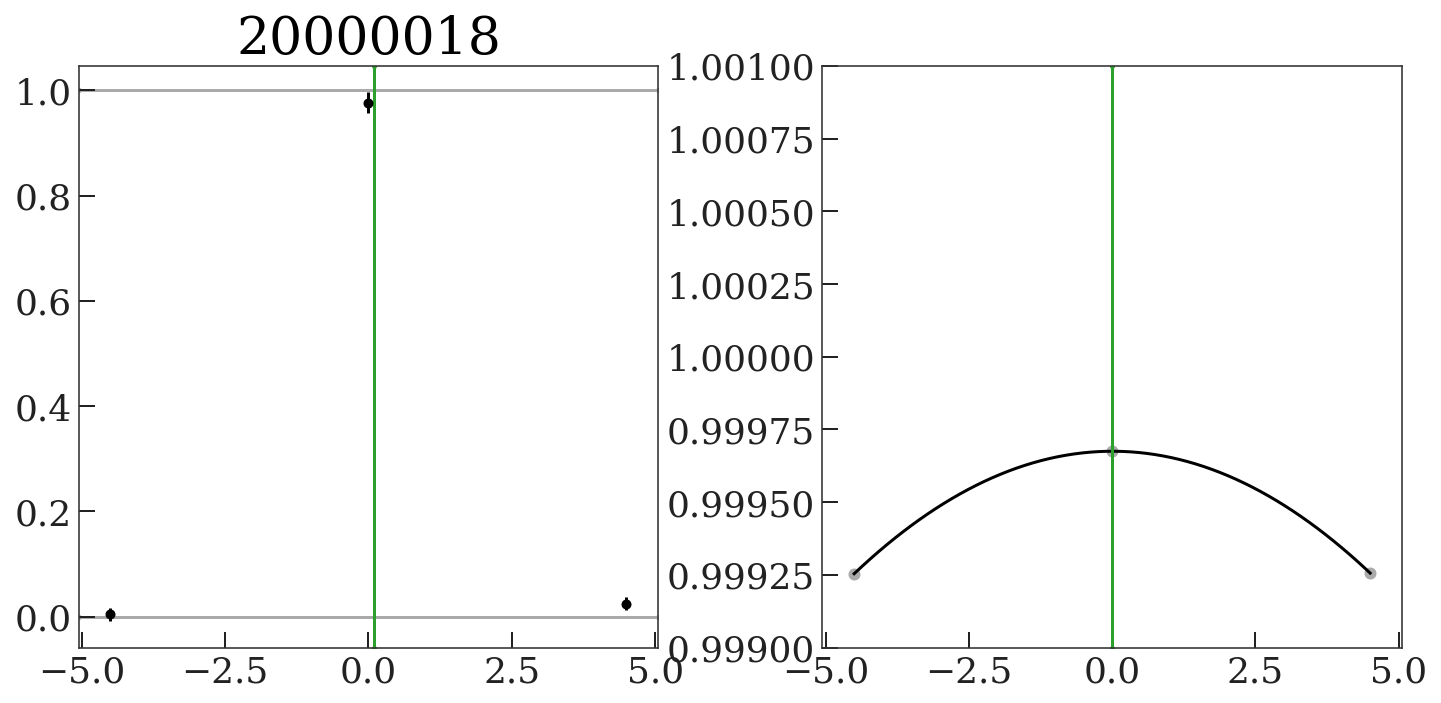

In [78]:
mjds = []
dvs = []
cc_dvs = []
for frame, s in sorted(spectra.items(), key=lambda x: int(x[0])):
    mjds.append(visit.frame_times[frame].mjd)
    
    normed_ref_spectrum, clip_mask = normalize_ref_to_frame(s, visit.spectrum, 
                                                            sigma_clip=False)
    kernel, kernel_cov, vs, cc = estimate_kernel(
        s, normed_ref_spectrum, 
        clip_mask=clip_mask, 
        K_half=1)
    
    cc_dv, cc_poly = parabola_hack(vs.value, cc)
    
    dvs.append(np.sum(kernel * vs.value) / np.sum(kernel))
    cc_dvs.append(cc_dv)
    
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(normed_ref_spectrum.wavelength.value,
#              normed_ref_spectrum.flux,
#              marker='', ls='-', lw=1,
#              drawstyle='steps-mid', alpha=0.7)
#     plt.plot(s.wavelength.value,
#              s.flux,
#              marker='', ls='-', lw=1,
#              drawstyle='steps-mid', alpha=0.7)
#     plt.xlim(16500, 16700)
#     # plt.ylim(0.5, 1.5)
    
#     if clip_mask is not None:
#         for val in s.wavelength.value[clip_mask]:
#             plt.axvline(val, color='tab:red', alpha=0.2, zorder=-100)
    
    # ---
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                             sharex=True)
    
    ax = axes[0]
    ax.errorbar(vs.value, kernel, np.sqrt(np.diag(kernel_cov)),
                marker='o', ls='none')
    
    ax.axhline(0, zorder=-10, color='#aaaaaa')
    ax.axhline(1, zorder=-10, color='#aaaaaa')
    ax.axvline(np.sum(kernel * vs.value) / np.sum(kernel), 
               color='tab:green')
    ax.set_title(frame)
    
    ax = axes[1]
    
    ax.scatter(vs.value, cc, color='#aaaaaa')
    grid = np.linspace(vs.value.min(), vs.value.max(), 128)
    ax.plot(grid, cc_poly(grid), marker='')
    ax.axvline(cc_dv, color='tab:green')
    ax.set_ylim(0.999, 1.001)
    
    fig.tight_layout()

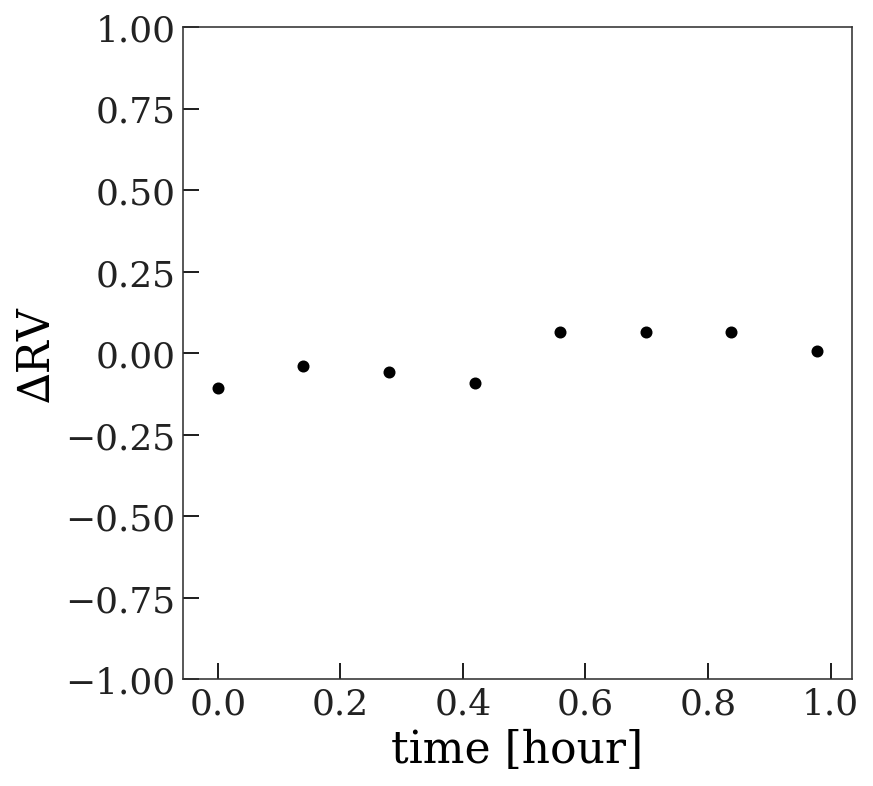

In [79]:
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(dvs))
# plt.scatter(np.array(mjds) - min(mjds), visit['VHELIO'] - np.array(cc_dvs))
# plt.plot(np.array(mjds) - min(mjds), orbit.radial_velocity(Time(mjds, format='mjd')))

fig = plt.figure()
# plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(dvs))
plt.scatter((np.array(mjds) - min(mjds)) * 24, np.array(cc_dvs))
plt.xlabel('time [hour]')
plt.ylabel('∆RV')
# plt.ylim(-5, 5)
plt.ylim(-1, 1)
fig.set_facecolor('w')

### TODO

- Multiple visits
- Plot visit velocities and frame velocities
- Compare stitching CC's and centroided velocities
- Improve the CC code to best practices (subtract the mean?)